# Publication plots:
## Setting up:
### Imports:

In [1]:
from matplotlib import pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import re
from pathlib import Path
import xarray as xr
import warnings
import re
from cmcrameri import cm
import plotly.graph_objects as go
import plotly.express as px
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV as RSCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, MaxNLocator

warnings.filterwarnings("ignore")

In [2]:
# Additional scripts:
from scripts.xgb_helpers import *
from scripts.xgb_input import *
from scripts.xgb_metrics import *
from scripts.xgb_model import *
from scripts.plots_clean import *
from scripts.xgb_extreme import *
from scripts.stakes_processing import *
%load_ext autoreload
%autoreload 2

### Parameters:

In [3]:
param_grid = {
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'n_estimators': np.arange(50, 300, 15),
    'max_depth': np.arange(3, 10, 1),
}
INPUT_TYPE = "MeteoSuisse"
KFOLD = True
NUM_FOLDS = 5
FOLD = 'kfold'

print('Seed:', SEED)

Seed: 5


In [4]:
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

# Colors:
palette_grays = sns.color_palette(np.tile("#878787", 6))
cmap = cm.devon
color_palette_glaciers = sns.color_palette(get_cmap_hex(cmap, 15))

# For bars and lines:
color_diff_xgb = '#878787'
color_diff_xgbplus = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 2)
color_xgbplus = colors[0]
color_tim = colors[1]
color_xgb = '#4575b4'

# Violin and boxplots:
colors_temp_freq = sns.color_palette(get_cmap_hex(cm.devon, 8))
boxplot_style = {
    "width": .6,
    "showcaps": False,
    "palette": colors_temp_freq,
    "flierprops": {
        "marker": "x"
    },
    "showmeans": True,
    "meanprops": {
        "markerfacecolor": "white"
    }
}

marker_tim = 's'
marker_xgb = 'o'
marker_std = '_'

### Setting up sites:

In [5]:
# Get number of sites per glacier and their names
glStakesNum, glStakes = get_StakesNum(path_GLAMOS_csv)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])

# Get total number of sites
num_stakes = 0
for (glacier, num) in (glStakes_sorted):
    num_stakes += num
print('Total number of stakes:', num_stakes)
print('Number of stakes per glacier:\n', glStakes_sorted)

# glacier names:
glaciers = list(glStakes.keys())
# Keep only the glaciers with more than 20 years of measurements
glStakes_20years, glStakes_20years_sorted, glStakes_20years_all = getStakesNyears(
    glaciers,
    glStakes,
    path_glacattr,
    path_era5_stakes,
    input_type=INPUT_TYPE,
    N=20)
print('\n----\nAfter preprocessing:\nNumber of glaciers:',
      len(glStakes_20years.keys()))
print('Number of stakes:', len(glStakes_20years_all))

# Rename stakes so that ordered by elevation from P1 to P(X highest):
names_stakes = rename_stakes(glStakes_20years)

Total number of stakes: 46
Number of stakes per glacier:
 [('sanktanna', 1), ('adler', 1), ('schwarzberg', 1), ('plainemorte', 1), ('allalin', 1), ('hohlaub', 1), ('corbassiere', 1), ('tsanfleuron', 2), ('gries', 2), ('pizol', 2), ('clariden', 2), ('pers', 2), ('murtel', 2), ('plattalva', 2), ('basodino', 3), ('rhone', 3), ('limmern', 3), ('silvretta', 3), ('gietro', 3), ('findelen', 4), ('aletsch', 6)]
1991 2023
1991 2023
1991 2023
2011 2023
2004 2023
2004 2023
2004 2023
2004 2023
2005 2023
2009 2023
2009 2023
1961 2023
1961 2023
2006 2023
2006 2023
2006 2023
1955 2023
Missing years: [2016, 2017, 2018, 2019, 2020]
1920 2023
1995 2023
1920 2023
1920 2023
1920 2023
1920 2023
1948 1984
1948 1984
1948 1984
2006 2021
2006 2021
2009 2023
1914 2023
1914 2023
1955 2023
1914 2023
1914 2023
1914 2023
1955 2023
2001 2023
2001 2023
2012 2023
2012 2023
1996 2023
1948 1984
1948 1984
1966 2023
1966 2023
1966 2023

----
After preprocessing:
Number of glaciers: 13
Number of stakes: 28


## Load models:

### PDD:

In [6]:
# Match only annual MB in PDD:
path_pdd_calb1 = path_pickles + f'{FOLD}/{INPUT_TYPE}/match_annual_winter/{SEED}/'  # Best param is average over best param per year
# path_pdd_calb2 = path_pickles + f'{FOLD}/{INPUT_TYPE}/calib_2.0/match_annual_winter/' # With grid search for param

var_pdd_a, metrics_pdd_a = assemblePDDStakes(path_pdd_calb1,
                                             glStakes_20years_all,
                                             names_stakes)

df_metrics_pdd = getDfMetrics(
    var_pdd_a, metrics_pdd_a, NUM_FOLDS,
    type_pred='annual_pred_PDD').sort_values(by='stakes_full')
df_metrics_pdd.head()

Reading files from: ../../data/MB_modeling/PDD/kfold/MeteoSuisse/match_annual_winter/5/


,glaciers,stakes,stakes_full,rmse_pdd_a_full,corr_pdd_a_full,mae_pdd_a_full,r2_pdd_a_full,num_points,std_obs,rmse_pdd_a_folds,corr_pdd_a_folds,mae_pdd_a_folds,r2_pdd_a_folds,rmse_pdd_a_std,corr_pdd_a_std,mae_pdd_a_std,r2_pdd_a_std
7,Aletsch,P1,ALE-P1,1.276439,0.290233,1.055389,0.084235,5.2,0.977507,1.203673,0.357935,1.039901,0.300810,0.357285,0.415563,0.298106,0.226722
9,Aletsch,P2,ALE-P2,0.497543,0.764770,0.398932,0.584873,5.0,0.657972,0.491243,0.686311,0.401502,0.518954,0.088763,0.218932,0.058186,0.272598
8,Aletsch,P3,ALE-P3,0.391454,0.860676,0.310898,0.740763,5.2,0.670663,0.384508,0.846424,0.311978,0.717281,0.081495,0.029116,0.080397,0.049179
10,Aletsch,P4,ALE-P4,0.560343,0.729897,0.445080,0.532749,11.0,0.660892,0.558203,0.758387,0.446309,0.587588,0.060333,0.111524,0.037409,0.156949
6,Aletsch,P5,ALE-P5,0.388781,0.826320,0.319775,0.682804,6.0,0.682448,0.368985,0.714308,0.319775,0.629928,0.122477,0.345966,0.116454,0.319392


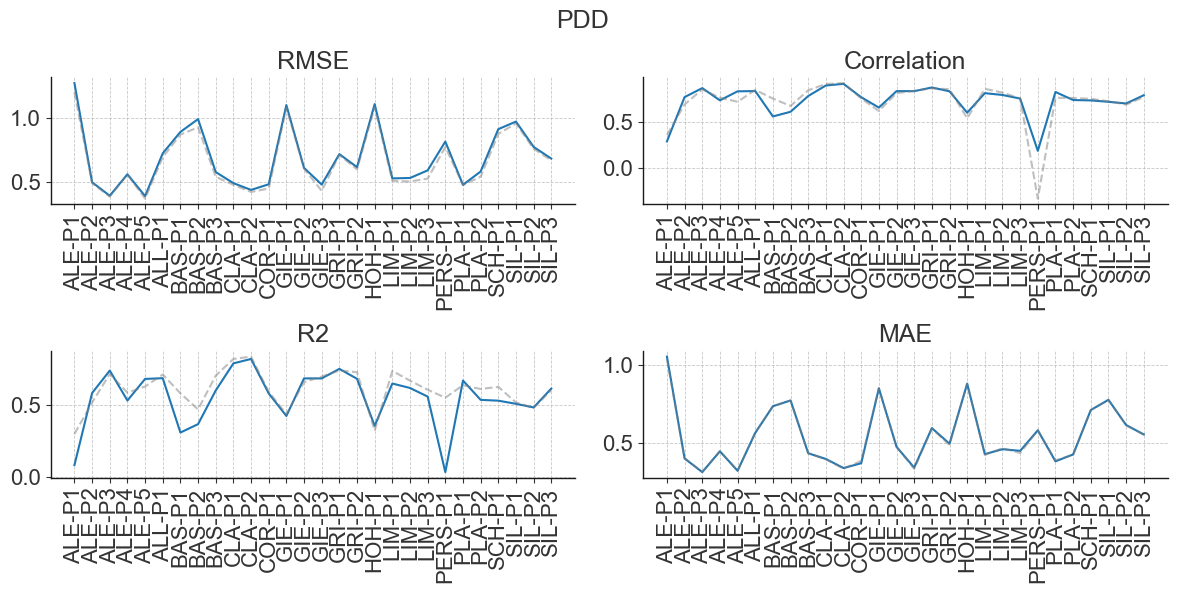

In [7]:
# Plot difference between corrected and mean over fold metrics:
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2, 2, 1)
ax1.plot(df_metrics_pdd.stakes_full,
         df_metrics_pdd.rmse_pdd_a_full,
         label='corrected')
ax1.plot(df_metrics_pdd.stakes_full,
         df_metrics_pdd.rmse_pdd_a_folds,
         label='old',
         alpha=0.5,
         color='gray',
         linestyle='--')
ax1.set_title('RMSE')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax1 = plt.subplot(2, 2, 2)
ax1.plot(df_metrics_pdd.stakes_full,
         df_metrics_pdd.corr_pdd_a_full,
         label='corrected')
ax1.plot(df_metrics_pdd.stakes_full,
         df_metrics_pdd.corr_pdd_a_folds,
         label='old',
         alpha=0.5,
         color='gray',
         linestyle='--')
ax1.set_title('Correlation')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax1 = plt.subplot(2, 2, 3)
ax1.plot(df_metrics_pdd.stakes_full,
         df_metrics_pdd.r2_pdd_a_full,
         label='corrected')
ax1.plot(df_metrics_pdd.stakes_full,
         df_metrics_pdd.r2_pdd_a_folds,
         label='old',
         alpha=0.5,
         color='gray',
         linestyle='--')
ax1.set_title('R2')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax1 = plt.subplot(2, 2, 4)
ax1.plot(df_metrics_pdd.stakes_full,
         df_metrics_pdd.mae_pdd_a_full,
         label='corrected')
ax1.plot(df_metrics_pdd.stakes_full,
         df_metrics_pdd.mae_pdd_a_folds,
         label='old',
         alpha=0.5,
         color='gray',
         linestyle='--')
ax1.set_title('MAE')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

plt.suptitle('PDD')

plt.tight_layout()

### XGBoost set ups:

In [8]:
path_xgb = path_save_xgboost_stakes + f'{FOLD}/{INPUT_TYPE}/'

# XGBoost monthly match annual MB:
var_xg_monthly, metrics_monthly = assembleXGStakes(
    path_xgb + 'monthly/t2m_tp/match_annual/', glStakes_20years_all,
    names_stakes)

var_xg_annual, metrics_annual = assembleXGStakes(
    path_xgb + 'annual/t2m_tp/match_annual/', glStakes_20years_all,
    names_stakes)

var_xg_half, metrics_half = assembleXGStakes(
    path_xgb + 'half_year/t2m_tp/match_annual/', glStakes_20years_all,
    names_stakes)

var_xg_seasonal, metrics_seasonal = assembleXGStakes(
    path_xgb + 'seasonal/t2m_tp/match_annual/', glStakes_20years_all,
    names_stakes)

# Match annual MB:
df_metrics_monthly = getDfMetrics(var_xg_monthly,
                                  metrics_monthly,
                                  NUM_FOLDS,
                                  type_pred="pred_XG")

# Annual XGBoost:
df_metrics_annual = getDfMetrics(var_xg_annual,
                                 metrics_annual,
                                 NUM_FOLDS,
                                 type_pred="pred_XG")

# Seasonal XGBoost:
df_metrics_seasonal = getDfMetrics(var_xg_seasonal,
                                   metrics_seasonal,
                                   NUM_FOLDS,
                                   type_pred="pred_XG")

# Half-yearly XGBoost:
df_metrics_half = getDfMetrics(var_xg_half,
                               metrics_half,
                               NUM_FOLDS,
                               type_pred="pred_XG")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/annual/t2m_tp/match_annual/var_basodino_P8.pkl'

### miniML-MB (opt. seasonal):

In [ ]:
VARS = ['t2m', 'tp']
# VARS = ['pdd', 'tp_corr']
# VARS = ['t2m', 'tp_weighted']

var_xg_best, metrics_best = assembleXGStakes(
    path_xgb + f'best_combi/grid_search_False/{VARS[0]}_{VARS[1]}/{SEED}/',
    glStakes_20years_all, names_stakes)

# var_xg_best, metrics_best = assembleXGStakes(
#     path_xgb + f'best_combi/grid_search_True/{VARS[0]}_{VARS[1]}/',
#     glStakes_20years_all, names_stakes)

df_metrics_best = getDfMetrics(var_xg_best,
                               metrics_best,
                               NUM_FOLDS,
                               type_pred="pred_XG")
df_metrics_best.head(2)

In [ ]:
var_xg_weighted, metrics_weighted = assembleXGStakes(
    path_xgb + f'best_combi/grid_search_False/t2m_tp_weighted/',
    glStakes_20years_all, names_stakes)
df_metrics_weighted = getDfMetrics(var_xg_weighted,
                                   metrics_weighted,
                                   NUM_FOLDS,
                                   type_pred="pred_XG")

## Plots:

### Fig 2: Heatmap of PMB per stake

#### From 1915:

In [ ]:
totalDF_mb, el_stakes = createHeatMatrixStakes(path_glacattr,
                                               glStakes_20years,
                                               COI,
                                               var="b_a_fix")
totalDF_mb_tr = totalDF_mb.transpose().reset_index()
stakes = totalDF_mb_tr['index']
gl_correct = [names_stakes[stake] for stake in stakes]
totalDF_mb_tr['stakeNames'] = gl_correct
totalDF_mb_tr = totalDF_mb_tr.drop(['index'], axis=1).set_index('stakeNames')

fig = plt.figure(figsize=(15, 10))

ax = sns.heatmap(data=totalDF_mb_tr,
                 center=0,
                 cmap=cm.vik_r,
                 cbar_kws={'label': '[m w.e.]'})
plt.title(
    'Annual point mass balance measurements per glacier stake as by GLAMOS survey',
    fontsize=16)
ax.set(xlabel="Years", ylabel="Stakes ordered by elevation")

print("Number of non NaN values:", totalDF_mb_tr.notna().sum().sum())

#### From 1961:

In [ ]:
totalDF_mb, el_stakes = createHeatMatrixStakes(path_glacattr,
                                               glStakes_20years,
                                               COI,
                                               var="b_a_fix")

DF60s = totalDF_mb[(totalDF_mb.index > 1961)]
totalDF_mb_tr = DF60s.transpose().reset_index()
stakes = totalDF_mb_tr['index']
gl_correct = [names_stakes[stake] for stake in stakes]

totalDF_mb_tr['stakeNames'] = gl_correct
totalDF_mb_tr = totalDF_mb_tr.drop(['index'], axis=1).set_index('stakeNames')

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
sns.heatmap(data=totalDF_mb_tr,
            center=0,
            cmap=cm.vik_r,
            cbar_kws={'label': '[m w.e. $a^{-1}$]'},
            ax=ax)
ax.set_ylabel('')
ax.set_xlabel("Years", fontsize=18)
plt.savefig("figures/fig1_stakesHeatmap.pdf",
            format="pdf",
            bbox_inches="tight")
print("Number of non NaN values:", totalDF_mb_tr.notna().sum().sum())

#### Elevation:

In [ ]:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(el_stakes.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')
plt.tight_layout()

### Fig 3&4: Conceptual framework & cross-testing

In [ ]:
stake = 'Clariden-P1'
stake_old = 'clariden_L'
input_vars = {"t2m": "temperature", "tp": "precipitation"}
df_stake = read_stake_csv(path_glacattr, f'{stake_old}_mb.csv')
xr_temppr = xr.open_dataset(path_MS + f"{stake_old}_mb_full.nc").sortby("time")
begin_xr = pd.to_datetime(xr_temppr["time"].values[0]).year
end_xr = pd.to_datetime(xr_temppr["time"].values[-1]).year

# Cut MB data to same years as xr era 5:
df_stake_cut = cutStake(df_stake, begin_xr, end_xr)
target_DF = df_stake_cut[df_stake_cut.vaw_id > 0]
target_DF['year'] = [
    target_DF.date_fix1.iloc[i].year for i in range(len(target_DF))
]

inputDF = createInputDF(df_stake_cut,
                        xr_temppr,
                        month_val=MONTH_VAL,
                        long_vars=input_vars,
                        input_type=INPUT_TYPE,
                        match="annual")
inputDF_winter = createInputDF(df_stake_cut,
                               xr_temppr,
                               month_val=MONTH_VAL,
                               long_vars=input_vars,
                               match="winter",
                               input_type=INPUT_TYPE)
input_ = {"annual": inputDF, "winter": inputDF_winter}

# XGBoost++:
predXGB = var_xg_best['pred_XG'][stake]
years = var_xg_best['feat_test'][stake]['time']
pred_DF = pd.DataFrame({'year': years, 'pred': predXGB})

fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharey=True)

sns.scatterplot(data=pred_DF,
                x='year',
                y='pred',
                ax=ax,
                color=color_xgbplus,
                marker=marker_xgb)
sns.lineplot(data=pred_DF, x='year', y='pred', ax=ax, color=color_xgbplus)
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend([], [], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)

plt.tight_layout()

In [ ]:
stake = 'Plattalva-P1'
stake_old = 'plattalva_P10'
input_vars = {"t2m": "temperature", "tp": "precipitation"}
df_stake = read_stake_csv(path_glacattr, f'{stake_old}_mb.csv')
xr_temppr = xr.open_dataset(path_MS + f"{stake_old}_mb_full.nc").sortby("time")
begin_xr = pd.to_datetime(xr_temppr["time"].values[0]).year
end_xr = pd.to_datetime(xr_temppr["time"].values[-1]).year

# Cut MB data to same years as xr era 5:
df_stake_cut = cutStake(df_stake, begin_xr, end_xr)
target_DF = df_stake_cut[df_stake_cut.vaw_id > 0]
target_DF['year'] = [
    target_DF.date_fix1.iloc[i].year for i in range(len(target_DF))
]

inputDF = createInputDF(df_stake_cut,
                        xr_temppr,
                        month_val=MONTH_VAL,
                        long_vars=input_vars,
                        input_type=INPUT_TYPE,
                        match="annual")
inputDF_winter = createInputDF(df_stake_cut,
                               xr_temppr,
                               month_val=MONTH_VAL,
                               long_vars=input_vars,
                               match="winter",
                               input_type=INPUT_TYPE)
input_ = {"annual": inputDF, "winter": inputDF_winter}

predXGB = var_xg_best['pred_XG'][stake]
years = var_xg_best['feat_test'][stake]['time']
pred_DF = pd.DataFrame({'year': years, 'pred': predXGB})

fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 1, 1)
plotSingleStakeLine(stake,
                    var_xg_best,
                    metrics_best,
                    ax1,
                    'grey',
                    kfold=True,
                    freq="",
                    scaled=False,
                    type_pred="pred_XG",
                    legend=False,
                    label='xgb')
ax1.set_title('')
ax1.set_ylabel('m w.e. a-1', fontsize=25)
ax1.set_xlabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=25)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=25)
plt.tight_layout()

### Fig 6: compare different aggregates:

In [ ]:
rmse, r2, freq, glacier, pearson, mae = [], [], [], [], [], []
frequencies = [
    'Annual',
    'Half-yearly',
    'Seasonal',
    'Opt. seasonal',
    'Monthly',
]

for i, df_met in enumerate([
        df_metrics_annual, df_metrics_half, df_metrics_seasonal,
        df_metrics_best, df_metrics_monthly
]):

    freq.append(np.tile(frequencies[i], len(df_met)))
    glacier.append(df_met.glaciers)

    if frequencies[i] == 'TIM':
        rmse.append(df_met[f'rmse_pdd_a_full'].values)
        mae.append(df_met[f'mae_pdd_a_full'].values)
        r2.append(df_met[f'r2_pdd_a_full'].values)
        pearson.append(df_met[f'corr_pdd_a_full'].values)
    else:
        rmse.append(df_met[f'rmse_xgb_full'].values)
        mae.append(df_met[f'mae_xgb_full'].values)
        r2.append(df_met[f'r2_xgb_full'].values)
        pearson.append(df_met[f'corr_xgb_full'].values)

df_freq = pd.DataFrame({
    'rmse': np.concatenate(rmse),
    'mae': np.concatenate(mae),
    'r2': np.concatenate(r2),
    'pearson': np.concatenate(pearson),
    'freq': np.concatenate(freq),
    'glacier': np.concatenate(glacier)
})

fig = plt.figure(figsize=(10, 10))
M, N = 2, 1

ax1 = plt.subplot(M, N, 1)
g = sns.boxplot(
    data=df_freq,
    x='freq',
    y='mae',
    #   hue = 'glacier',
    ax=ax1,
    **boxplot_style)
ax1.set_ylabel('MAE [m w.e.]', fontsize=20)
ax1.set_xlabel('')
ax1.legend([], [], frameon=False)
# ax1.set_title('MAE(miniML) over all stakes', fontsize=20)
ax1.tick_params(axis='both',
                labelsize=20)  # You can change 14 to your desired font size

ax2 = plt.subplot(M, N, 2)
g = sns.boxplot(data=df_freq, x='freq', y='pearson', ax=ax2, **boxplot_style)
ax2.set_ylabel('$\\rho$', fontsize=20)
ax2.tick_params(axis='both',
                labelsize=20)  # You can change 14 to your desired font size
ax2.set_xlabel('')

plt.suptitle('Evaluation metrics of miniML-MB over all sites', fontsize=20)
plt.tight_layout()
plt.savefig("figures/fig6_aggr_boxplot.pdf", format="pdf", bbox_inches="tight")

### Fig 7a: Truth vs Pred:

In [ ]:
all_preds_best = np.concatenate(
    [var_xg_best['pred_XG'][stake]
     for stake in var_xg_best['pred_XG'].keys()]) / (1000)
all_preds = np.concatenate([
    var_xg_monthly['pred_XG'][stake]
    for stake in var_xg_monthly['pred_XG'].keys()
]) / (1000)
all_preds_pdd = np.concatenate([
    var_pdd_a['annual_pred_PDD'][stake]
    for stake in var_pdd_a['annual_pred_PDD'].keys()
]) / (1000)
all_targets = np.concatenate([
    np.concatenate(var_xg_best['feat_test'][stake]['target_test'])
    for stake in var_xg_best['feat_test'].keys()
]) / (1000)

all_stakes = []
for stake in var_xg_best['feat_test'].keys():
    for fold in range(NUM_FOLDS):
        all_stakes.append(
            np.tile(stake,
                    len(var_xg_best['feat_test'][stake]['target_test'][fold])))
all_stakes = np.concatenate(all_stakes)

rmse_xgb_best = df_metrics_best[f'rmse_xgb_full'].mean()
mae_xgb_best = df_metrics_best[f'mae_xgb_full'].mean()
r2_xgb_best = df_metrics_best[f'r2_xgb_full'].mean()
rho_xgb_best = df_metrics_best[f'corr_xgb_full'].mean()

rmse_xgb = df_metrics_monthly[f'rmse_xgb_full'].mean()
mae_xgb = df_metrics_monthly[f'mae_xgb_full'].mean()
r2_xgb = df_metrics_best[f'r2_xgb_full'].mean()

rmse_pdd = df_metrics_pdd[f'rmse_pdd_a_full'].mean()
mae_pdd = df_metrics_pdd[f'mae_pdd_a_full'].mean()
r2_pdd = df_metrics_pdd[f'r2_pdd_a_full'].mean()
rho_pdd = df_metrics_pdd[f'corr_pdd_a_full'].mean()

legend_xgb_best = "\n".join((
    r"$\mathrm{MAE_{miniML}}=%.3f, \mathrm{RMSE_{miniML}}=%.3f$ " % (
        mae_xgb_best,
        rmse_xgb_best,
    ),
    r"$\mathrm{\rho_{miniML}}=%.2f$ " % (rho_xgb_best, ),
    r"$\mathrm{MAE_{PDD}}=%.3f, \mathrm{RMSE_{PDD}}=%.3f$ " % (
        mae_pdd,
        rmse_pdd,
    ),
    r"$\mathrm{\rho_{PDD}}=%.2f$ " % (rho_pdd, ),
))

fig = plt.figure(figsize=(15, 8))
ax1 = plt.subplot(1, 2, 1)

predVsTruth(ax1,
            all_targets,
            all_preds_pdd,
            np.tile(1, len(all_preds)),
            color=color_tim,
            label='PDD',
            custom_legend_text='',
            alpha=0.5,
            marker=marker_tim)

predVsTruth(ax1,
            all_targets,
            all_preds_best,
            np.tile(1, len(all_preds)),
            color=color_xgbplus,
            label='miniML-MB',
            custom_legend_text=legend_xgb_best,
            alpha=0.5,
            marker=marker_xgb)
ax1.set_ylabel('Predicted PMB [m w.e.]', fontsize=20)
ax1.set_xlabel('Observed PMB [m w.e.]', fontsize=20)
ax1.legend(loc='lower right', fontsize=20)
plt.tight_layout()

plt.savefig("figures/fig_scatter_all.pdf", format="pdf", bbox_inches="tight")

In [ ]:
dfAll = pd.DataFrame({
    'stakes':
    np.concatenate([all_stakes, all_stakes, all_stakes]),
    'preds':
    np.concatenate([all_preds, all_preds_best, all_preds_pdd]),
    'target':
    np.concatenate([all_targets, all_targets, all_targets]),
    'model':
    np.concatenate([
        np.tile('xgb', len(all_targets)),
        np.tile('xgb++', len(all_targets)),
        np.tile('pdd', len(all_targets))
    ])
})
dfAll_xgb = dfAll[dfAll.model.apply(lambda x: x in ['xgb++', 'pdd'])]

px.scatter(dfAll_xgb,
           x='target',
           y='preds',
           color='model',
           hover_data=['stakes'])

### Standard deviation:

In [ ]:
# What is the MAE of putting the average measured PMB for each site:
pred_ML_std, pred_PDD_std, std_obs = [], [], []
for stake in var_xg_best['feat_test'].keys():
    pred_ML_std.append(np.std(var_xg_best['pred_XG'][stake]) / (1000))
    pred_PDD_std.append(np.std(var_pdd_a['annual_pred_PDD'][stake]) / (1000))
    std_obs.append(
        np.std(np.concatenate(var_xg_best['feat_test'][stake]['target_test']))
        / (1000))

# average over all stakes:
pred_std = pd.DataFrame({
    'stake':
    var_xg_best['pred_XG'].keys(),
    'ML-std':
    pred_ML_std,
    'PDD-std':
    pred_PDD_std,
    'std-obs':
    std_obs,
    'diff_std': (np.abs(np.array(pred_ML_std) - np.array(std_obs))) - np.abs(
        (np.array(pred_PDD_std) - np.array(std_obs)))
})
pred_std['stakes_full'] = [
    GL_SHORT[stake.split("-")[0]] + "-" + stake.split("-")[1]
    for stake in pred_std.stake
]
pred_std = pred_std.sort_values(by='stake')
pred_std.head(2)

In [ ]:
pred_std_c = pred_std.merge(df_metrics_best[['corr_xgb_full', 'stakes_full']],
                            on='stakes_full')

smallest_var = pred_std_c.sort_values(
    by=['ML-std'], ascending=True).iloc[:5].stakes_full.values
smallest_corr = pred_std_c.sort_values(
    by=['corr_xgb_full'], ascending=True).iloc[:5].stakes_full.values
smallest_var, smallest_corr

In [ ]:
alpha = 0.8
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
sns.scatterplot(pred_std,
                x='stakes_full',
                y=f'std-obs',
                ax=ax,
                marker='_',
                color=color_diff_xgbplus,
                label='Obs')
sns.scatterplot(pred_std,
                x='stakes_full',
                y=f'PDD-std',
                ax=ax,
                alpha=alpha,
                marker=marker_tim,
                color=color_tim,
                label='PDD')
g = sns.scatterplot(pred_std,
                    x='stakes_full',
                    y=f'ML-std',
                    ax=ax,
                    alpha=alpha,
                    color=color_xgbplus,
                    marker=marker_xgb,
                    s=200,
                    label='miniML-MB')
h, l = g.get_legend_handles_labels()
ax.grid(axis='both', linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(h,
          l,
          bbox_to_anchor=(1.05, 1),
          loc=2,
          ncol=1,
          borderaxespad=0.0,
          fontsize=16)
ax.set_ylabel('std [m w.e.]', fontsize=16)
ax.set_xlabel('Sites', fontsize=18)
ax.set_title('Standard deviation of measured and predicted PMB', fontsize=18)
plt.tight_layout()
plt.savefig("figures/fig_app_standard_deviations.pdf",
            format="pdf",
            bbox_inches="tight")


### Fig 7b: different metrics

In [ ]:
fig = plt.figure(figsize=(18, 10))
M, N = 2, 2

alpha = 0.8
fontsize_title = 28

ax1 = plt.subplot(M, N, 1)
sns.scatterplot(df_metrics_best,
                x='stakes_full',
                y=f'std_obs',
                ax=ax1,
                marker='_',
                color=color_diff_xgbplus)
sns.scatterplot(df_metrics_pdd,
                x='stakes_full',
                y=f'mae_pdd_a_full',
                ax=ax1,
                alpha=alpha,
                marker=marker_tim,
                color=color_tim)
g = sns.scatterplot(df_metrics_best,
                    x='stakes_full',
                    y=f'mae_xgb_full',
                    ax=ax1,
                    alpha=alpha,
                    color=color_xgbplus,
                    marker=marker_xgb,
                    s=200)
ax1.grid(axis='both', linestyle='--')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('[m w.e.]', fontsize=20)
ax1.set_title('$\mathrm{MAE(miniML)}$ vs $\mathrm{MAE(PDD)}$',
              fontsize=fontsize_title)
ax1.set_ylim(bottom=0)

ax2 = plt.subplot(M, N, 2)
sns.scatterplot(df_metrics_pdd,
                x='stakes_full',
                y=f'corr_pdd_a_full',
                ax=ax2,
                alpha=alpha,
                marker=marker_tim,
                color=color_tim)
g = sns.scatterplot(df_metrics_best,
                    x='stakes_full',
                    y=f'corr_xgb_full',
                    ax=ax2,
                    alpha=alpha,
                    color=color_xgbplus,
                    marker=marker_xgb,
                    s=200)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_ylim(top=1)
ax2.set_title(
    '$\mathrm{\\rho}(\mathrm{miniML})$ vs $\mathrm{\\rho}(\mathrm{PDD})$',
    fontsize=fontsize_title)
ax2.set_ylabel('')

# Diff MAE:
ax3 = plt.subplot(M, N, 3)
df_diff_best = calcDiff(df_metrics_best, df_metrics_pdd)
g = sns.barplot(
    df_diff_best,
    x='stakes_full',
    y='diff_mae_wrt_to_std',
    ax=ax3,
    dodge=False,
    color=color_diff_xgbplus,
    alpha=alpha,
)
ax3.axhline(-0.1, color='gray', linestyle='--', alpha=0.5)
ax3.axhline(0.1, color='gray', linestyle='--', alpha=0.5)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
ax3.set_ylim(bottom=-0.6, top=0.2)
ax3.set_ylabel('% w.r.t std of observed PMB ', fontsize=20)
ax3.set_title('$\mathrm{MAE}(\mathrm{miniML})-\mathrm{MAE}(\mathrm{PDD})$',
              fontsize=fontsize_title)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax4 = plt.subplot(M, N, 4)
g = sns.barplot(
    df_diff_best,
    x='stakes_full',
    y=f'diff_corr_xgb_full',
    ax=ax4,
    dodge=False,
    alpha=alpha,
    color=color_diff_xgbplus,
)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
ax4.set_title('$\mathrm{\\rho}(\mathrm{miniML})-\mathrm{\\rho}(\mathrm{PDD})$',
              fontsize=fontsize_title)
ax4.set_ylabel('')

for ax in [ax1, ax2, ax3, ax4]:
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)

plt.tight_layout()
plt.savefig("figures/fig_barplotxgboost++_all.pdf",
            format="pdf",
            bbox_inches="tight")

In [ ]:
stake_full = 'HOH-P1'
stake_df = df_metrics_best[df_metrics_best.stakes_full == stake_full]
stake_df_pdd = df_metrics_pdd[df_metrics_pdd.stakes_full == stake_full]
stake_df['mae_xgb_full'] - stake_df_pdd['mae_pdd_a_full'], stake_df_pdd[
    'std_obs'], (stake_df['mae_xgb_full'] -
                 stake_df_pdd['mae_pdd_a_full']) / (stake_df_pdd['std_obs'])

### Fig: Examples of XGBoost++:

In [ ]:
stakeNames = [
    'Plattalva-P2', 'Silvretta-P2', 'Clariden-P2', 'Aletsch-P4', 'Hohlaub-P1',
    'Aletsch-P1'
]
stakesFull = ['PLA-P2', 'SIL-P2', 'CLA-P2', 'ALE-P4', 'HOH-P1', 'ALE-P1']
colors_cbfriendly = get_cmap_hex(cm.batlow, len(MONTH_VAL.keys()))
palette = {}
for ind in MONTH_VAL.keys():
    palette[MONTH_VAL[ind]] = colors_cbfriendly[ind - 1]
palette_grays = sns.color_palette(np.tile("#8CA6D9", len(var_pdd_a.keys())))

f, axs = plt.subplots(len(stakeNames),
                      2,
                      figsize=(15, 18),
                      gridspec_kw={"width_ratios": [1, 4]})

for row, stake in enumerate(stakeNames):
    ax1 = axs[row, 0]
    ax2 = axs[row, 1]

    stake_full = stakesFull[row]

    legend_pdd = plotSingleStake(stake,
                                 var_pdd_a,
                                 metrics_pdd_a,
                                 ax1,
                                 ax2,
                                 kfold=KFOLD,
                                 freq="",
                                 type_pred="annual_pred_PDD",
                                 color=color_tim,
                                 legend=False,
                                 label="PDD",
                                 marker=marker_tim)
    legend_xgb = plotSingleStake(stake,
                                 var_xg_best,
                                 metrics_best,
                                 ax1,
                                 ax2,
                                 kfold=KFOLD,
                                 freq="",
                                 color=color_xgbplus,
                                 legend=False,
                                 label='miniML',
                                 type_pred="pred_XG",
                                 marker=marker_xgb)

    # add legend:
    df_stake = df_metrics_best[df_metrics_best['stakes_full'].apply(
        lambda x: x == stake_full)]
    df_pdd = df_metrics_pdd[df_metrics_pdd['stakes_full'].apply(
        lambda x: x == stake_full)]
    mae_xgb = df_stake[f"mae_xgb_full"]
    pearson_xgb = df_stake[f"corr_xgb_full"]
    pearson_pdd = df_pdd[f"corr_pdd_a_full"]
    mae_pdd = df_pdd[f"mae_pdd_a_full"]

    std_ml = np.std(var_xg_best['pred_XG'][stake]) / (1000)
    std_pdd = np.std(var_pdd_a['annual_pred_PDD'][stake]) / (1000)

    legend_text = "\n".join((
        r"$\mathrm{MAE}_{\mathrm{miniML}}=%.3f, \mathrm{\rho}_{\mathrm{miniML}}=%.2f, \mathrm{std}_{\mathrm{miniML}}=%.2f$"
        % (
            mae_xgb,
            pearson_xgb,
            std_ml,
        ),
        (r"$\mathrm{MAE}_{\mathrm{PDD}}=%.3f,\mathrm{\rho}_{\mathrm{PDD}}=%.2f, \mathrm{std}_{\mathrm{PDD}}=%.2f$"
         % (mae_pdd, pearson_pdd, std_pdd)),
    ))
    ax2.text(0.02,
             0.02,
             legend_text,
             transform=ax2.transAxes,
             verticalalignment="bottom",
             fontsize=16)

    ax2.tick_params(axis='both', labelsize=20)
    ax1.tick_params(axis='both', labelsize=20)
    # ax2.set_title(stake)

plt.tight_layout()

plt.savefig("figures/fig8_examples_xgb++.pdf",
            format="pdf",
            bbox_inches="tight")

### Examples of low correlation:

In [ ]:
possible_var = [['t2m', 'tp_weighted'], ['pdd', 'tp']]
var_xg_best_t2m_tp_weighted, metrics_best_t2m_tp_weighted = assembleXGStakes(
    path_xgb + f'best_combi/grid_search_False/t2m_tp_weighted/',
    glStakes_20years_all, names_stakes)
df_metrics_best_t2m_tp_weighted = getDfMetrics(var_xg_best_t2m_tp_weighted,
                                               metrics_best,
                                               NUM_FOLDS,
                                               type_pred="pred_XG")

var_xg_best_pdd_tp, metrics_best_pdd_tp = assembleXGStakes(
    path_xgb + f'best_combi/grid_search_False/pdd_tp/', glStakes_20years_all,
    names_stakes)
df_metrics_best_pdd_tp = getDfMetrics(var_xg_best_pdd_tp,
                                      metrics_best,
                                      NUM_FOLDS,
                                      type_pred="pred_XG")

In [ ]:
# stakeNames = ['Schwarzberg-P1', 'Aletsch-P1', 'Basodino-P1', 'Basodino-P2', 'Pers-P1']
# stakesFull = ['SCH-P1', 'ALE-P1', 'BAS-P1', 'BAS-P2', 'PERS-P1']

stakeNames = ['Aletsch-P1', 'Basodino-P1', 'Basodino-P2']
stakesFull = ['ALE-P1', 'BAS-P1', 'BAS-P2']

colors_cbfriendly = get_cmap_hex(cm.batlow, len(MONTH_VAL.keys()))
palette = {}
for ind in MONTH_VAL.keys():
    palette[MONTH_VAL[ind]] = colors_cbfriendly[ind - 1]
palette_grays = sns.color_palette(np.tile("#8CA6D9", len(var_pdd_a.keys())))

f, axs = plt.subplots(len(stakeNames),
                      2,
                      figsize=(15, 8),
                      gridspec_kw={"width_ratios": [1, 4]})

# Load another seed
var_xg_best_newseed, metrics_best_newseed = assembleXGStakes(
    path_xgb + f'best_combi/grid_search_False/{VARS[0]}_{VARS[1]}/2/',
    glStakes_20years_all, names_stakes)

df_metrics_best_newseed = getDfMetrics(var_xg_best_newseed,
                                       metrics_best_newseed,
                                       NUM_FOLDS,
                                       type_pred="pred_XG")

for row, stake in enumerate(stakeNames):
    ax1 = axs[row, 0]
    ax2 = axs[row, 1]

    stake_full = stakesFull[row]

    legend_pdd = plotSingleStake(stake,
                                 var_pdd_a,
                                 metrics_pdd_a,
                                 ax1,
                                 ax2,
                                 kfold=KFOLD,
                                 freq="",
                                 type_pred="annual_pred_PDD",
                                 color=color_tim,
                                 legend=False,
                                 label="PDD",
                                 marker=marker_tim)
    legend_xgb = plotSingleStake(stake,
                                 var_xg_best_newseed,
                                 metrics_best_newseed,
                                 ax1,
                                 ax2,
                                 kfold=KFOLD,
                                 freq="",
                                 color=color_xgbplus,
                                 legend=False,
                                 label='miniML',
                                 type_pred="pred_XG",
                                 marker=marker_xgb)

    # add legend:
    df_stake = df_metrics_best_newseed[df_metrics_best_newseed['stakes_full'].
                                       apply(lambda x: x == stake_full)]
    df_pdd = df_metrics_pdd[df_metrics_pdd['stakes_full'].apply(
        lambda x: x == stake_full)]
    mae_xgb = df_stake[f"mae_xgb_full"]
    pearson_xgb = df_stake[f"corr_xgb_full"]
    pearson_pdd = df_pdd[f"corr_pdd_a_full"]
    mae_pdd = df_pdd[f"mae_pdd_a_full"]

    std_ml = np.std(var_xg_best_newseed['pred_XG'][stake]) / (1000)
    std_pdd = np.std(var_pdd_a['annual_pred_PDD'][stake]) / (1000)

    legend_text = "\n".join((
        r"$\mathrm{MAE}_{miniML}=%.3f, \mathrm{\rho}_{miniML}=%.2f, \mathrm{std}_{miniML}=%.2f$"
        % (
            mae_xgb,
            pearson_xgb,
            std_ml,
        ),
        (r"$\mathrm{MAE}_{PDD}=%.3f,\mathrm{\rho}_{PDD}=%.2f, \mathrm{std}_{PDD}=%.2f$"
         % (mae_pdd, pearson_pdd, std_pdd)),
    ))
    ax2.text(0.02,
             0.02,
             legend_text,
             transform=ax2.transAxes,
             verticalalignment="bottom",
             fontsize=16)

    ax2.tick_params(axis='both', labelsize=20)
    ax1.tick_params(axis='both', labelsize=20)
    ax2.set_title(stake)

plt.tight_layout()


In [ ]:
# stakes with low variability:
stakes_low = [
    'Schwarzberg-P1', 'Aletsch-P1', 'Basodino-P1', 'Basodino-P2', 'Pers-P1'
]
# stakes_low_names = ['schwarzberg_P2', 'aletsch_P0', 'basodino_P10', 'basodino_P5', 'pers_P24']
stakes_low_names = names_stakes.keys()
plotAttrsStakes(var_xg_monthly, names_stakes, stakes_low_names, stakes_low)

In [ ]:
figure = plt.figure(figsize=(8, 5))

stake_grid_alt, stake_alt = getSurfaceHeight(glStakes_20years.keys(),
                                             glStakes_20years,
                                             input_type="MeteoSuisse")

# PLOT
ax = plt.subplot(1, 1, 1)
stakes_low = ['SCH-P1', 'ALE-P1', 'BAS-P1', 'BAS-P2', 'PERS-P1']

stake_grid_alt_new = {
    names_stakes[key]: stake_grid_alt[key]
    for key in stakes_low_names
}
stake_alt_new = {names_stakes[key]: stake_alt[key] for key in stakes_low_names}

ax.scatter(stake_grid_alt_new.keys(),
           stake_grid_alt_new.values(),
           label=f'MS-grid')
ax.scatter(stake_alt_new.keys(),
           stake_alt_new.values(),
           label='stake',
           color='grey')
ax.legend()
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel('[m]')
ax.set_xlabel('Stakes')
ax.set_title(f'Elevation of stake and closest MS grid cell')
plt.tight_layout()


### Days between homogenization:

In [ ]:
days_between_winter, days_between_annual = {}, {}
stakesShort = []
for stake in names_stakes.keys():
    df = pd.read_csv(path_glacattr + f'{stake}_mb.csv')
    # winter MB
    days_spring = []
    for i in range(len(df)):
        spring_season = f'{datetime.strptime(df.date_smeas.iloc[i], "%Y-%m-%d").year}-04-30'
        days_spring.append(days_between(df.date_smeas.iloc[i], spring_season))
    days_between_winter[stake] = days_spring
    # annual MB
    days_between_annual[stake] = [
        days_between(df.date1.iloc[i], df.date_fix1.iloc[i])
        for i in range(len(df))
    ]
    nameStake = names_stakes[stake]
    stakesShort.append(
        np.tile(
            GL_SHORT[nameStake.split("-")[0]] + "-" + nameStake.split("-")[1],
            len(df)))
df_days = pd.DataFrame({
    'shift_winter_MB':
    np.concatenate(list(days_between_winter.values())),
    'shift_annual_MB':
    np.concatenate(list(days_between_annual.values())),
    'stake':
    np.concatenate(stakesShort)
}).sort_values(by='stake')

fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
sns.boxplot(df_days, x='stake', y='shift_winter_MB', **boxplot_style)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel('Num days')
ax.set_title('Diff. between annual meas. and 04-30 (start hyd. year)')

ax = plt.subplot(1, 2, 2)
sns.boxplot(df_days, x='stake', y='shift_annual_MB', **boxplot_style)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel('Num days')
ax.set_title('Diff. between annual meas. and 09-30 (end hyd. year)')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
sns.boxplot(df_days, y='shift_winter_MB', ax=ax, **boxplot_style)
ax = plt.subplot(1, 2, 2, sharey=ax)
sns.boxplot(df_days, y='shift_annual_MB', ax=ax, **boxplot_style)
plt.tight_layout()

In [ ]:
np.percentile(df_days.shift_annual_MB, 75), np.percentile(
    df_days.shift_annual_MB,
    25), np.mean(df_days.shift_annual_MB), np.std(df_days.shift_annual_MB)

In [ ]:
np.percentile(df_days.shift_winter_MB, 75), np.percentile(
    df_days.shift_winter_MB,
    25), np.mean(df_days.shift_winter_MB), np.std(df_days.shift_winter_MB)

### Compare naive to best:

In [ ]:
fig = plt.figure(figsize=(15, 5))
M, N = 1, 2

# Diff MAE:
ax1 = plt.subplot(
    M,
    N,
    1,
)
df_diff = calcDiff(df_metrics_monthly, df_metrics_pdd)
g = sns.barplot(
    df_diff,
    x='stakes_full',
    # y=f'diff_mae_xgb_full',
    y='diff_mae_wrt_to_std',
    # hue='glaciers',
    ax=ax1,
    dodge=False,
    # palette=color_palette_glaciers,
    color=color_diff_xgb,
    alpha=0.8)
h, l = g.get_legend_handles_labels()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.legend(
    h,
    l,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=2,
    borderaxespad=0.0,
)
ax1.set_title('$\mathrm{MAE(miniML_{monthly})-MAE(PDD)}$', fontsize=20)
# ax1.set_ylabel('[m w.e.]', fontsize=18)
ax1.set_ylabel('% w.r.t std of observed PMB ', fontsize=18)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2 = plt.subplot(M, N, 2, sharey=ax1)
df_diff_best = calcDiff(df_metrics_best, df_metrics_pdd)
g = sns.barplot(
    df_diff_best,
    x='stakes_full',
    # y=f'diff_mae_xgb_full',
    y='diff_mae_wrt_to_std',
    # hue='glaciers',
    ax=ax2,
    dodge=False,
    alpha=0.8,
    color=color_diff_xgbplus,
    # palette=color_palette_glaciers
)
h, l = g.get_legend_handles_labels()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.legend(
    h,
    l,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=2,
    borderaxespad=0.0,
)
ax2.set_ylabel('')
ax2.set_title('$\mathrm{MAE(miniML_{opt.seas.})-MAE(PDD)}$', fontsize=20)
# ax2.set_xticks([])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for ax in [ax1, ax2]:
    ax.legend([], [], frameon=False)
    ax.set_xlabel('Sites', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)

plt.tight_layout()
plt.savefig("figures/fig_app_monthly_opt_seasonal.pdf",
            format="pdf",
            bbox_inches="tight")

### Compare two forms of PDD:

In [ ]:
# Match only annual MB in PDD:
path_pdd_calb1 = path_pickles + f'{FOLD}/{INPUT_TYPE}/match_annual_winter/'  # Best param is average over best param per year
path_pdd_calb2 = path_pickles + f'{FOLD}/{INPUT_TYPE}/calib_2.0/match_annual_winter/'  # With grid search for param

var_pdd_a, metrics_pdd_a = assemblePDDStakes(path_pdd_calb1,
                                             glStakes_20years_all,
                                             names_stakes)

df_metrics_pdd = getDfMetrics(
    var_pdd_a, metrics_pdd_a, NUM_FOLDS,
    type_pred='annual_pred_PDD').sort_values(by='stakes_full')

var_pdd_a_2, metrics_pdd_a_2 = assemblePDDStakes(path_pdd_calb2,
                                                 glStakes_20years_all,
                                                 names_stakes)

df_metrics_pdd_2 = getDfMetrics(
    var_pdd_a_2, metrics_pdd_a_2, NUM_FOLDS,
    type_pred='annual_pred_PDD').sort_values(by='stakes_full')

fig = plt.figure(figsize=(15, 5))
M, N = 1, 2

# Diff MAE:
ax1 = plt.subplot(
    M,
    N,
    1,
)
df_diff = calcDiff(df_metrics_best, df_metrics_pdd)
g = sns.barplot(df_diff,
                x='stakes_full',
                y='diff_mae_wrt_to_std',
                ax=ax1,
                dodge=False,
                color=color_diff_xgb,
                alpha=0.8)
h, l = g.get_legend_handles_labels()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.legend(
    h,
    l,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=2,
    borderaxespad=0.0,
)
ax1.set_title('$\mathrm{MAE(miniML_{opt.seas.})-MAE(PDD_{avgy})}$',
              fontsize=20)
ax1.set_ylabel('% w.r.t std of observed PMB ', fontsize=18)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2 = plt.subplot(M, N, 2, sharey=ax1)
df_diff_best = calcDiff(df_metrics_best, df_metrics_pdd_2)
g = sns.barplot(
    df_diff_best,
    x='stakes_full',
    y='diff_mae_wrt_to_std',
    ax=ax2,
    dodge=False,
    alpha=0.8,
    color=color_diff_xgbplus,
)
h, l = g.get_legend_handles_labels()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.legend(
    h,
    l,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=2,
    borderaxespad=0.0,
)
ax2.set_ylabel('')
ax2.set_title('$\mathrm{MAE(miniML_{opt.seas.})-MAE(PDD_{grid})}$',
              fontsize=20)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for ax in [ax1, ax2]:
    ax.legend([], [], frameon=False)
    ax.set_xlabel('Sites', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)

plt.tight_layout()
# plt.savefig("figures/fig_app_monthly_opt_seasonal.pdf",
#             format="pdf",
#             bbox_inches="tight")

In [ ]:
palette = sns.color_palette("tab10")
calib1_DDF, calib2_DDF, calib1_c, calib2_c, stakes = [], [], [], [], []
for stake in var_pdd_a['feat_train'].keys():
    kf = KFold(n_splits=5, shuffle=False)
    for i, (train_index, test_index) in enumerate(
            kf.split(var_pdd_a['feat_train'][stake]['DDFsnow'])):
        calib1_DDF.append(
            np.mean(var_pdd_a['feat_train'][stake]['DDFsnow'][test_index]))
        calib1_c.append(
            np.mean(var_pdd_a['feat_train'][stake]['c_prec'][test_index]))
        stakes.append(GL_SHORT[stake.split("-")[0]] + "-" +
                      stake.split("-")[1])
    calib2_DDF.append(var_pdd_a_2['feat_train'][stake]['DDFsnow'])
    calib2_c.append(var_pdd_a_2['feat_train'][stake]['c_prec'])

calib1 = pd.DataFrame({
    'stake': stakes,
    'DDF': calib1_DDF,
    'c_prec': calib1_c,
    'type': 'mean over years'
})

calib2 = pd.DataFrame({
    'stake': stakes,
    'DDF': np.concatenate(calib2_DDF),
    'c_prec': np.concatenate(calib2_c),
    'type': 'grid search'
})
calibdf = pd.concat([calib1, calib2], axis=0)

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
g = sns.scatterplot(calibdf,
                    x='stake',
                    y='DDF',
                    ax=ax,
                    hue='type',
                    palette=palette)
ax.set_ylabel(f"DDF")

ax = plt.subplot(2, 2, 2)
g = sns.scatterplot(calibdf,
                    x='stake',
                    y='c_prec',
                    ax=ax,
                    hue='type',
                    palette=palette)
ax.set_ylabel(f"c_prec")

ax = plt.subplot(2, 2, 3)
sns.scatterplot(df_metrics_pdd,
                x='stakes_full',
                y='mae_pdd_a_full',
                ax=ax,
                color=palette[0],
                label='mean over years')
sns.scatterplot(df_metrics_pdd_2,
                x='stakes_full',
                y='mae_pdd_a_full',
                ax=ax,
                color=palette[1],
                label='grid search')

for ax in plt.gcf().axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("")

plt.tight_layout()

In [ ]:
stake = 'Aletsch-P1'
stake_full = 'ALE-P1'
PlotCompareXGBoostplus(stake,
                       stake_full,
                       var_pdd_a_2,
                       metrics_pdd_a_2,
                       df_metrics_pdd_2,
                       var_xg_best,
                       metrics_best,
                       df_metrics_best,
                       kfold=KFOLD,
                       p1=0.02,
                       p2=0.02,
                       color_xgb=color_xgbplus,
                       color_tim=color_tim,
                       marker_xgb=marker_xgb,
                       marker_tim=marker_tim,
                       type_pred="pred_XG",
                       add_pdd=True,
                       label_xgb="miniML")

### Compare different training variables:

In [ ]:
M, N = 2, 1
fig, axs = plt.subplots(M, N, figsize=(15, 12), sharey=True)

colors = {'t2m': color_diff_xgbplus, 'pdd': color_tim}
possible_var = [['t2m', 'tp'], ['pdd', 'tp']]
for i, VARS in enumerate(possible_var):
    var_xg_best, metrics_best = assembleXGStakes(
        path_xgb + f'best_combi/grid_search_False/{VARS[0]}_{VARS[1]}/',
        glStakes_20years_all, names_stakes)

    df_metrics_best = getDfMetrics(var_xg_best,
                                   metrics_best,
                                   NUM_FOLDS,
                                   type_pred="pred_XG")

    # Diff MAE:
    df_diff_best = calcDiff(df_metrics_best, df_metrics_pdd)
    g = sns.barplot(
        df_diff_best,
        x='stakes_full',
        # y=f'diff_mae_xgb_full',
        y='diff_mae_wrt_to_std',
        ax=axs[0],
        dodge=True,
        alpha=0.8,
        color=colors[VARS[0]],
        label=f'{VARS[0]} & {VARS[1]}')
h, l = g.get_legend_handles_labels()
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].legend(
    h,
    l,
    # bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=1,
    borderaxespad=0.0,
    fontsize="18")
# axs[0].set_ylabel('[m w.e. a$^{-1}$]', fontsize=18)
axs[0].set_ylabel('% w.r.t std of observed PMB ', fontsize=18)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[0].set_xlabel('', fontsize=20)
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=18)

possible_var = [['t2m', 'tp'], ['t2m', 'tp_weighted']]
colors = {'tp': color_diff_xgbplus, 'tp_weighted': color_tim}
for i, VARS in enumerate(possible_var):
    var_xg_best, metrics_best = assembleXGStakes(
        path_xgb + f'best_combi/grid_search_False/{VARS[0]}_{VARS[1]}/',
        glStakes_20years_all, names_stakes)

    df_metrics_best = getDfMetrics(var_xg_best,
                                   metrics_best,
                                   NUM_FOLDS,
                                   type_pred="pred_XG")
    df_metrics_best_corrected = dfMetricsCorrected(var_xg_best,
                                                   NUM_FOLDS,
                                                   type_pred="pred_XG")

    # Diff MAE:
    df_diff_best = calcDiff(df_metrics_best, df_metrics_pdd)
    if VARS[1] == 'tp_weighted':
        label = f't2m_w & tp_w'
    else:
        label = f'{VARS[0]} & {VARS[1]}'
    g = sns.barplot(
        df_diff_best,
        x='stakes_full',
        # y=f'diff_mae_xgb_full',y
        y='diff_mae_wrt_to_std',
        ax=axs[1],
        dodge=True,
        alpha=0.8,
        color=colors[VARS[1]],
        label=label)
h, l = g.get_legend_handles_labels()
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].legend(
    h,
    l,
    # bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=1,
    borderaxespad=0.0,
    fontsize="18")
# axs[1].set_ylabel('[m w.e.]', fontsize=18)
axs[1].set_ylabel('% w.r.t std of observed PMB ', fontsize=18)
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[1].set_xlabel('Sites', fontsize=20)
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=18)

plt.suptitle('$\mathrm{MAE(miniML-MB)-MAE(PDD)}$', fontsize=20)
plt.tight_layout()

plt.savefig("figures/fig_app_pdd.pdf", format="pdf", bbox_inches="tight")

In [ ]:
M, N = 2, 1
fig, axs = plt.subplots(M, N, figsize=(15, 12), sharey=True)

colors = {'t2m': color_diff_xgbplus, 'pdd': color_tim}
possible_var = [['t2m', 'tp'], ['pdd', 'tp']]
for i, VARS in enumerate(possible_var):
    var_xg_best, metrics_best = assembleXGStakes(
        path_xgb + f'best_combi/grid_search_False/{VARS[0]}_{VARS[1]}/',
        glStakes_20years_all, names_stakes)

    df_metrics_best = getDfMetrics(var_xg_best,
                                   metrics_best,
                                   NUM_FOLDS,
                                   type_pred="pred_XG")

    # Diff Correlation:
    df_diff_best = calcDiff(df_metrics_best, df_metrics_pdd)
    g = sns.barplot(
        df_diff_best,
        x='stakes_full',
        # y=f'diff_Correlation_xgb_full',
        y='diff_corr_xgb_full',
        ax=axs[0],
        dodge=True,
        alpha=0.8,
        color=colors[VARS[0]],
        label=f'{VARS[0]} & {VARS[1]}')
h, l = g.get_legend_handles_labels()
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].legend(
    h,
    l,
    # bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=1,
    borderaxespad=0.0,
    fontsize="18")
# axs[0].set_ylabel('[m w.e.]', fontsize=18)
axs[0].set_ylabel('% w.r.t std of observed PMB ', fontsize=18)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[0].set_xlabel('', fontsize=20)
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=18)

possible_var = [['t2m', 'tp'], ['t2m', 'tp_weighted']]
colors = {'tp': color_diff_xgbplus, 'tp_weighted': color_tim}
for i, VARS in enumerate(possible_var):
    var_xg_best, metrics_best = assembleXGStakes(
        path_xgb + f'best_combi/grid_search_False/{VARS[0]}_{VARS[1]}/',
        glStakes_20years_all, names_stakes)

    df_metrics_best = getDfMetrics(var_xg_best,
                                   metrics_best,
                                   NUM_FOLDS,
                                   type_pred="pred_XG")
    df_metrics_best_corrected = dfMetricsCorrected(var_xg_best,
                                                   NUM_FOLDS,
                                                   type_pred="pred_XG")

    # Diff Correlation:
    df_diff_best = calcDiff(df_metrics_best, df_metrics_pdd)
    if VARS[1] == 'tp_weighted':
        label = f't2m_w & tp_w'
    else:
        label = f'{VARS[0]} & {VARS[1]}'
    g = sns.barplot(
        df_diff_best,
        x='stakes_full',
        # y=f'diff_Correlation_xgb_full',y
        y='diff_corr_xgb_full',
        ax=axs[1],
        dodge=True,
        alpha=0.8,
        color=colors[VARS[1]],
        label=label)
h, l = g.get_legend_handles_labels()
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].legend(
    h,
    l,
    # bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=1,
    borderaxespad=0.0,
    fontsize="18")
# axs[1].set_ylabel('[m w.e.]', fontsize=18)
axs[1].set_ylabel('% w.r.t std of observed PMB ', fontsize=18)
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[1].set_xlabel('Sites', fontsize=20)
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=18)

plt.suptitle('$\mathrm{Correlation(miniML-MB)-Correlation(PDD)}$', fontsize=20)
plt.tight_layout()

plt.savefig("figures/fig_app_pdd.pdf", format="pdf", bbox_inches="tight")

### Gap filling: complete missing years:


In [ ]:
var_xg_monthly, metrics_monthly = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_annual/', glStakes_20years_all,
    names_stakes)
hp_lr = metrics_monthly['hp_lr']
hp_ne = metrics_monthly['hp_ne']
hp_md = metrics_monthly['hp_md']
RUN = True
if RUN:
    for stake in tqdm(names_stakes.values()):
        position = list(names_stakes.values()).index(stake)
        stake_old = list(names_stakes.keys())[position]
        stakeShort = GL_SHORT[stake.split("-")[0]] + "-" + stake.split("-")[1]
        custom_params_RF = {
            'learning_rate': hp_lr[stake],
            'n_estimators': int(hp_ne[stake]),
            'max_depth': int(hp_md[stake])
        }
        extrm_years_t2m, extrm_years_tp = GapFilling(
            stake,
            stake_old,
            INPUT_TYPE,
            param_grid,
            custom_params_RF=custom_params_RF,
            grid_search=False)

In [ ]:
stake = 'Aletsch-P4'
stakeShort = GL_SHORT[stake.split("-")[0]] + "-" + stake.split("-")[1]
print(stakeShort)
position = list(names_stakes.values()).index(stake)
stake_old = list(names_stakes.keys())[position]

# read pickle
with open(path_save_xgboost_stakes + "gap_filling/" + "var_" + stake + ".pkl",
          "rb") as fp:
    var_xg_missing = pickle.load(fp)
vars_ = ['t2m', 'tp']
best_combi = [(['t2m_May', 't2m_June', 't2m_July', 't2m_Aug'], [
    'tp_Oct',
    'tp_Nov',
    'tp_Dec',
    'tp_Jan',
    'tp_Feb',
])]

var_xg_missing_df = pd.DataFrame(var_xg_missing)
extrm_years_t2m = var_xg_missing_df[var_xg_missing_df.is_extr_t2m ==
                                    True].time.values
extrm_years_tp = var_xg_missing_df[var_xg_missing_df.is_extr_tp ==
                                   True].time.values
extrm_years_t2m

weights_t2m = np.ones(len(best_combi[0][0]))
weights_tp = np.ones(len(best_combi[0][1]))

f, axs = plt.subplots(
    3,
    2,
    figsize=(15, 10),
    gridspec_kw={"width_ratios": [2, 4]},
)
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

plotInputExtrm(best_combi, weights_t2m, weights_tp, stake_old, INPUT_TYPE,
               vars_, ax3, ax4, ax1, ax2, extrm_years_t2m, extrm_years_tp)
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='both', labelsize=20)

ax5 = axs[2, 0]
ax6 = axs[2, 1]
plotExtremePreds(stake,
                 stakeShort,
                 ax5,
                 ax6,
                 var_pdd_a,
                 metrics_pdd_a,
                 df_metrics_pdd,
                 var_xg_best,
                 metrics_best,
                 df_metrics_best,
                 var_xg_missing,
                 KFOLD,
                 color_tim,
                 color_xgbplus,
                 marker_tim,
                 marker_xgb,
                 connect=True)
ax6.set_xlabel('Time', fontsize=20)
plt.suptitle(stake, fontsize=20)
plt.tight_layout()
var_xg_missing_df.dropna().time.values

In [ ]:
missingYears = {
    'Aletsch-P4': [1993, 1994, 1995, 1996, 2001],
    'Gietro-P3': [1962, 1963, 1964, 1965, 1966, 1974],
    'Gietro-P2': [1962, 1963, 1964, 1965, 1966, 1993, 1994, 1995, 1996],
    'Hohlaub-P1':
    [1968, 1969, 1971, 1997, 1998, 1999, 2001, 2002, 2003, 2005, 2006, 2007],
    'Silvretta-P3': [1985, 1986, 1987],
    'Aletsch-P3': [1987, 1988, 1989, 1990, 1991],
    'Pers-P1':
    [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001],
    'Plattalva-P1': [1985, 1986, 1987, 1988, 1989, 1990, 1991],
    'Gietro-P1': [1993, 1994],
    'Plattalva-P2': [1985, 1986, 1987, 1988, 1989, 1990, 1991],
    'Limmern-P3': [1985, 1986, 1987, 1988, 1989, 1990, 1991],
    'Schwarzberg-P1': [1968, 1969, 1970, 1971, 1972, 1979],
    'Silvretta-P2': [1985, 1986],
    'Basodino-P1': [1989, 1990, 1991],
    'Limmern-P2': [1985, 1986, 1987, 1988, 1989, 1990, 1991],
    'Silvretta-P1': [1985, 1986],
    'Limmern-P1': [1985, 1986, 1987, 1988, 1989, 1990, 1991],
}
len(missingYears)

In [ ]:
totalDF_mb, el_stakes = createHeatMatrixStakes(path_glacattr,
                                               glStakes_20years,
                                               COI,
                                               var="b_a_fix")

DF60s = totalDF_mb[(totalDF_mb.index > 1961)]
# Complete the heatmap:
incomplete_stakes = [
    re.split('_', f)[1][:-4]
    for f in os.listdir(path_save_xgboost_stakes + "gap_filling/")
]
for stake in incomplete_stakes:
    if stake in missingYears.keys():
        position = list(names_stakes.values()).index(stake)
        stake_old = list(names_stakes.keys())[position]

        incomplete = DF60s[stake_old]

        with open(
                path_save_xgboost_stakes + "gap_filling/" + "var_" + stake +
                ".pkl", "rb") as fp:
            var_xg_missing = pickle.load(fp)
        var_xg_missing_df = pd.DataFrame(var_xg_missing)
        var_xg_missing_df = var_xg_missing_df.dropna()

        filled_vals = pd.Series(var_xg_missing_df['pred_xgb'].values,
                                index=var_xg_missing_df['time'])
        filled_vals = filled_vals.loc[missingYears[stake]]

        incomplete.loc[filled_vals.index] = filled_vals.values
        DF60s[stake_old] = incomplete

totalDF_mb_tr = DF60s.transpose().reset_index()
stakes = totalDF_mb_tr['index']
gl_correct = [names_stakes[stake] for stake in stakes]

totalDF_mb_tr['stakeNames'] = gl_correct
totalDF_mb_tr = totalDF_mb_tr.drop(['index'], axis=1).set_index('stakeNames')

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
sns.heatmap(data=totalDF_mb_tr,
            center=0,
            cmap=cm.vik_r,
            cbar_kws={'label': '[m w.e.]'},
            ax=ax)
ax.set_ylabel('')
ax.set_xlabel("Years", fontsize=18)
plt.savefig("figures/fig1_stakesHeatmap.pdf",
            format="pdf",
            bbox_inches="tight")
print("Number of non NaN values:", totalDF_mb_tr.notna().sum().sum())

### Compare length of time series and performance:

In [ ]:
totalDF_mb, el_stakes = createHeatMatrixStakes(path_glacattr,
                                               glStakes_20years,
                                               COI,
                                               var="b_a_fix")

DF60s = totalDF_mb[(totalDF_mb.index > 1961)]
totalDF_mb_tr = DF60s.transpose().reset_index()
stakes = totalDF_mb_tr['index']
gl_correct = [names_stakes[stake] for stake in stakes]
totalDF_mb_tr['stakeNames'] = gl_correct
totalDF_mb_tr = totalDF_mb_tr.drop(['index'], axis=1).set_index('stakeNames')
# Number of measurements per stake:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 1, 1)
totalDF_mb_tr.notna().sum(axis=1).sort_values(ascending=False).plot(kind='bar',
                                                                    ax=ax)
ax.axhline(20, linestyle='--', color='red')
ax.set_title("Number of measurements per stake")

In [ ]:
df_metrics_best['stakeNames'] = [
    df_metrics_best['glaciers'].iloc[i] + '-' +
    df_metrics_best['stakes'].iloc[i] for i in range(len(df_metrics_best))
]
df_metrics_best['ts_length'] = [
    totalDF_mb_tr.notna().sum(axis=1).loc[stake]
    for stake in df_metrics_best['stakeNames']
]
df_metrics_best['mae_wrt_to_std'] = df_metrics_best[
    'mae_xgb_full'] / df_metrics_best['std_obs']
ax = plt.subplot(1, 1, 1)
sns.scatterplot(data=df_metrics_best, x='ts_length', y='mae_wrt_to_std', ax=ax)
correlation = df_metrics_best[['ts_length', 'mae_wrt_to_std']].corr().iloc[0,
                                                                           1]
correlation

### Figs: Comparaison corrected and fold metrics:
Can either take the mean of metrics over each fold or the metric over the whole reconstructed time series.

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2, 2, 1)
ax1.plot(df_metrics_best.stakes_full,
         df_metrics_best.rmse_xgb_full,
         label='full ts')
ax1.plot(df_metrics_best.stakes_full,
         df_metrics_best.rmse_xgb_folds,
         label='folds',
         alpha=0.5,
         color='gray',
         linestyle='--')
ax1.set_title('RMSE')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax1 = plt.subplot(2, 2, 2)
ax1.plot(df_metrics_best.stakes_full,
         df_metrics_best.corr_xgb_full,
         label='full ts')
ax1.plot(df_metrics_best.stakes_full,
         df_metrics_best.corr_xgb_folds,
         label='folds',
         alpha=0.5,
         color='gray',
         linestyle='--')
ax1.set_title('Correlation')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax1 = plt.subplot(2, 2, 3)
ax1.plot(df_metrics_best.stakes_full,
         df_metrics_best.r2_xgb_full,
         label='full ts')
ax1.plot(df_metrics_best.stakes_full,
         df_metrics_best.r2_xgb_folds,
         label='folds',
         alpha=0.5,
         color='gray',
         linestyle='--')
ax1.set_title('R2')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax1 = plt.subplot(2, 2, 4)
ax1.plot(df_metrics_best.stakes_full,
         df_metrics_best.mae_xgb_full,
         label='full ts')
ax1.plot(df_metrics_best.stakes_full,
         df_metrics_best.mae_xgb_folds,
         label='folds',
         alpha=0.5,
         color='gray',
         linestyle='--')
ax1.set_title('MAE')
ax1.legend()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

plt.suptitle('XGBoost++: difference between metric over fold or timeseries')
plt.tight_layout()

In [ ]:
figure = plt.figure(figsize=(18, 10))
ax = plt.subplot(2, 3, 1)
sns.scatterplot(
    df_metrics_best,
    x='stakes_full',
    y='rmse_xgb_full',
    ax=ax,
    marker='o',
    label='whole TS',
    size='num_points',
)
sns.scatterplot(df_metrics_best,
                x='stakes_full',
                y='rmse_xgb_folds',
                ax=ax,
                alpha=0.5,
                marker='s',
                color='gray',
                label='mean with std')
for i, txt in enumerate(df_metrics_best["stakes_full"]):
    ax.errorbar(
        df_metrics_best["stakes_full"][i],
        df_metrics_best["rmse_xgb_folds"][i],
        df_metrics_best["rmse_xgb_std"][i],
        linestyle="None",
        color="grey",
        alpha=0.5,
        marker=None,
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend([], [], frameon=False)
ax.set_ylabel('RMSE (m w.e.)')
ax.set_title('RMSE XGBoost++')

ax = plt.subplot(2, 3, 2)
sns.scatterplot(
    df_metrics_best,
    x='stakes_full',
    y='mae_xgb_full',
    ax=ax,
    marker='o',
    label='whole TS',
    size='num_points',
)
sns.scatterplot(df_metrics_best,
                x='stakes_full',
                y='mae_xgb_folds',
                ax=ax,
                alpha=0.5,
                marker='s',
                color='gray',
                label='mean with std')
for i, txt in enumerate(df_metrics_best["stakes_full"]):
    ax.errorbar(
        df_metrics_best["stakes_full"][i],
        df_metrics_best["mae_xgb_folds"][i],
        df_metrics_best["mae_xgb_std"][i],
        linestyle="None",
        color="grey",
        alpha=0.5,
        marker=None,
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend([], [], frameon=False)
ax.set_ylabel('MAE (m w.e.)')
ax.set_title('MAE XGBoost++')

ax = plt.subplot(2, 3, 3)
sns.scatterplot(df_metrics_best,
                x='stakes_full',
                y='r2_xgb_folds',
                color='gray',
                ax=ax,
                alpha=0.5,
                marker='s',
                label='mean with std')

g = sns.scatterplot(
    df_metrics_best,
    x='stakes_full',
    y='r2_xgb_full',
    ax=ax,
    marker='o',
    label='whole TS',
    size='num_points',
)
for i, txt in enumerate(df_metrics_best["stakes_full"]):
    ax.errorbar(
        df_metrics_best["stakes_full"][i],
        df_metrics_best["r2_xgb_folds"][i],
        df_metrics_best["r2_xgb_std"][i],
        linestyle="None",
        color="grey",
        alpha=0.5,
        marker=None,
    )
ax.set_ylabel('$R^2$')
h, l = g.get_legend_handles_labels()
ax.legend(h,
          l,
          bbox_to_anchor=(1.05, 1),
          loc=2,
          ncol=1,
          borderaxespad=0.0,
          title='Number of test points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('$R^2$ XGBoost++')

ax = plt.subplot(2, 3, 4)
sns.scatterplot(
    df_metrics_pdd,
    x='stakes_full',
    y='rmse_pdd_a_full',
    ax=ax,
    marker='o',
    label='whole TS',
    size='num_points',
)
sns.scatterplot(df_metrics_pdd,
                x='stakes_full',
                y='rmse_pdd_a_folds',
                ax=ax,
                alpha=0.5,
                marker='s',
                color='gray',
                label='mean with std')
for i, txt in enumerate(df_metrics_pdd["stakes_full"]):
    ax.errorbar(
        df_metrics_pdd["stakes_full"][i],
        df_metrics_pdd["rmse_pdd_a_folds"][i],
        df_metrics_pdd["rmse_pdd_a_std"][i],
        linestyle="None",
        color="grey",
        alpha=0.5,
        marker=None,
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend([], [], frameon=False)
ax.set_ylabel('RMSE (m w.e.)')
ax.set_title('RMSE PDD')

ax = plt.subplot(2, 3, 5)
sns.scatterplot(
    df_metrics_pdd,
    x='stakes_full',
    y='mae_pdd_a_full',
    ax=ax,
    marker='o',
    label='whole TS',
    size='num_points',
)
sns.scatterplot(df_metrics_pdd,
                x='stakes_full',
                y='mae_pdd_a_folds',
                ax=ax,
                alpha=0.5,
                marker='s',
                color='gray',
                label='mean with std')
for i, txt in enumerate(df_metrics_pdd[f"stakes_full"]):
    ax.errorbar(
        df_metrics_pdd[f"stakes_full"][i],
        df_metrics_pdd["mae_pdd_a_folds"][i],
        df_metrics_pdd["mae_pdd_a_std"][i],
        linestyle="None",
        color="grey",
        alpha=0.5,
        marker=None,
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend([], [], frameon=False)
ax.set_ylabel('MAE (m w.e.)')
ax.set_title('MAE PDD')

ax = plt.subplot(2, 3, 6)
sns.scatterplot(
    df_metrics_pdd,
    x=f'stakes_full',
    y=f'r2_pdd_a_full',
    ax=ax,
    marker='o',
    label='whole TS',
    size='num_points',
)
sns.scatterplot(df_metrics_pdd,
                x=f'stakes_full',
                y=f'r2_pdd_a_folds',
                color='gray',
                ax=ax,
                alpha=0.5,
                marker='s',
                label='mean with std')
for i, txt in enumerate(df_metrics_pdd[f"stakes_full"]):
    ax.errorbar(
        df_metrics_pdd[f"stakes_full"][i],
        df_metrics_pdd["r2_pdd_a_folds"][i],
        df_metrics_pdd["r2_pdd_a_std"][i],
        linestyle="None",
        color="grey",
        alpha=0.5,
        marker=None,
    )
ax.set_ylabel('$R^2$')
ax.legend([], [], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('$R^2$ PDD')
plt.tight_layout()

### Fig: Violin plots LASSO and Naive XGBoost:

In [ ]:
def getViolinPlot(df_metrics_annual, df_metrics_half, df_metrics_seasonal,
                  df_metrics_monthly, model):
    dic_freq = {
        'annual': df_metrics_annual,
        'half-y': df_metrics_half,
        'seasonal': df_metrics_seasonal,
        'monthly': df_metrics_monthly
    }
    rmse, mae, freq_t = [], [], []
    for key in dic_freq.keys():
        rmse.append(dic_freq[key][f'rmse_{model}'])
        mae.append(dic_freq[key][f'mae_{model}'])
        freq_t.append(np.tile(key, len(dic_freq[key])))

    df_freq = pd.DataFrame({
        f'rmse_{model}': np.concatenate(rmse),
        f'mae_{model}': np.concatenate(mae),
        'freq': np.concatenate(freq_t),
        'stakes': np.tile(df_metrics_annual.stakes, 4),
        'glacier': np.tile(df_metrics_annual.glaciers, 4)
    })
    return df_freq


dic_freq_lasso = getViolinPlot(df_metrics_lasso_annual,
                               df_metrics_lasso_half,
                               df_metrics_lasso_seasonal,
                               df_metrics_lasso_monthly,
                               model='lasso')

dic_freq_xgb = getViolinPlot(df_metrics_annual,
                             df_metrics_half,
                             df_metrics_seasonal,
                             df_metrics_monthly,
                             model=f'xgb_full')

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 2, 1)
sns.violinplot(dic_freq_lasso,
               x='freq',
               y=f'rmse_lasso',
               ax=ax,
               palette=colors_temp_freq)
ax.set_ylabel('RMSE [m w.e. y-1]')
ax.set_title('Lasso Regression')
ax.set_xlabel('Frequency')

ax2 = plt.subplot(1, 2, 2, sharey=ax)
sns.violinplot(dic_freq_xgb,
               x='freq',
               y=f'rmse_xgb_full',
               ax=ax2,
               palette=colors_temp_freq)
ax2.set_ylabel('')
ax2.set_xlabel('Frequency')
ax2.set_title('Naive XGBoost')

plt.tight_layout()
# plt.savefig("figures/fig4_violin_plot.pdf", format="pdf", bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(18, 10))
M, N = 2, 2

long_name, ylabel = get_long_name_metric('rmse')

ax1 = plt.subplot(M, N, 3)
evalPlot(df_metrics_pdd.sort_values(by='stakes_full'),
         ax1,
         metric=f'rmse_pdd_a_full',
         color_palette=palette_grays,
         alpha=0.5,
         frequency=None,
         add_std=False)
evalPlot(df_metrics_monthly.sort_values(by='stakes_full'),
         ax1,
         metric=f'rmse_xgb_full',
         color_palette=color_palette_glaciers,
         frequency=None,
         add_std=False)
ax1.set_title(f'{long_name}(Lasso) vs {long_name}(TIM) (in grey)')

ax2 = plt.subplot(M, N, 4, sharey=ax1)
evalPlot(df_metrics_pdd.sort_values(by='stakes_full'),
         ax2,
         metric=f'rmse_pdd_a_full',
         color_palette=palette_grays,
         alpha=0.5,
         frequency=None,
         add_std=False)
evalPlot(df_metrics_lasso_monthly.sort_values(by='stakes_full'),
         ax2,
         metric=f'rmse_lasso',
         color_palette=color_palette_glaciers,
         frequency=None,
         add_std=False)
ax2.set_title(f'{long_name}(Lasso) vs {long_name}(TIM) (in grey)')

ax3 = plt.subplot(M, N, 1)

df_diff = calcDiff(df_metrics_monthly, df_metrics_pdd, suffix=SUFFIX)

evalPlot(df_diff.sort_values(by='stakes_full'),
         ax3,
         metric=f'diff_rmse_xgb_full',
         add_std=False,
         color_palette=color_palette_glaciers,
         frequency=None,
         type_='bar')

ax4 = plt.subplot(M, N, 2, sharey=ax3)

df_diff_lasso = df_metrics_lasso_monthly.merge(df_metrics_pdd[[
    'stakes_full', f'rmse_pdd_a_full', f'mae_pdd_a_full', f'corr_pdd_a_full',
    f'r2_pdd_a_full'
]],
                                               on='stakes_full')
df_diff_lasso[f'diff_rmse_lasso'] = (df_diff_lasso[f'rmse_lasso'] -
                                     df_diff_lasso[f'rmse_pdd_a_full'])

evalPlot(df_diff_lasso.sort_values(by='stakes_full'),
         ax4,
         metric=f'diff_rmse_lasso',
         add_std=False,
         color_palette=color_palette_glaciers,
         frequency=None,
         type_='bar')
ax4.set_title(f'{long_name}(Lasso)-{long_name}(TIM) per stake')

for ax in [ax1, ax2, ax3]:
    ax.legend([], [], frameon=False)
for ax in [ax2, ax4]:
    ax.set_ylabel('')
plt.tight_layout()